# Summary

This Jupyter notebook will introduce in programming a machine learning based code with Scikit-learn. A regression model is used as first example to outline the general workflow for a machine learning project. 

# My first machine learning project

We will go through following main steps which are typical for a machine learning project:
1. Look at the big picture.
2. Get the data.
3. Explore and visualize the data.
4. Prepare the data for the machine learning algorithm.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your model and make it ready for later usage.

## Look at the big picture

The energy of a hydrogen bond (HB) is not directly accessible by static quantum chemistry calculations. It would be beneficial to determine it from some local properties to understand for example which HBs are most important for a drug in a binding pocket of a protein. Linear regression models were proposed in the literature (e.g. J. Phys. Chem. A 2010, 114, 35, 9529-9536) which use values from the electron density or distances between atoms to predict the HB energy. However, these models should fail in predicting HB energies where the geometry is affected by cooperative effects. Your task is to train a machine learning model superior to simple linear regression models.

What do we know about our algorithm:
1. It should be a supervised technique. A good performance measure would be the root mean squared error (RMSE).
   $$
    RMSE(\mathbf{X},h) = \sqrt{\frac{1}{m}\sum\limits_{i=1}^{m}\left(h(\mathbf{x}^{(i)})-y^{(i)}\right)^2}
   $$
   $m$ is the number of instances $i$ in the data set, $\mathbf{X}$ is a matrix including all input feature values except the labels, $\mathbf{x}^{(i)}$ is the vector of the input features of the $i^{th}$ instance, $y^{(i)}$ is the label of the $i^{th}$ instance and $h$ is the prediction function, also called hypothesis. The RMSE, also called Euclidian norm or $l_2$-norm, provides an information on the error of the fit with a higher weight for large errors. An error of less then 4 kJ/mol is desirable. This is often referred as reaching chemical accuracy. However, typical hydrogen bonds are in the range between 15 and 30 kJ/mol. Thus, reaching a lower error would be better. Nonetheless, below 1 kJ/mol will be in the error range of the labels of the training data.   
2. There is no particular need to adjust rapidly to changing data. 
3. The data set for developing the model is of small size (9 input features, 1 label, 1638 instances in total). Thus, the data is small enough to fit into memory.


## Get the data

We will use pandas to read in a csv file which is in the same file as your Jupyter notebook:

In [1]:
import pandas as pd

hb_data = pd.read_csv('HB_data.csv')
# If you want to read in from a directory you can use following lines:
# from pathlib import Path
# path = Path('path-to-my-data/HB_data.csv')
# HB_data = pd.read_csv(path)

# We will look on the first 5 instances to check if it was imported successfully. Please note, it starts counting with 0 instead of 1:
print(f"Following data was read (showing only first 5 rows):\n{hb_data.head()}")

Following data was read (showing only first 5 rows):
    energy  bo-acc  bo-donor     q-acc   q-donor   q-hatom   dist-dh  \
0 -34.5895  0.2457    0.8981 -0.088121  0.069022  0.030216  1.029201   
1 -39.2652  0.2061    0.9089 -0.100112  0.070940  0.042037  1.027247   
2 -41.0025  0.1748    0.9185 -0.108372  0.072666  0.050028  1.025135   
3 -40.8874  0.1496    0.9269 -0.114255  0.074115  0.055766  1.023101   
4 -39.6642  0.1289    0.9341 -0.118741  0.075412  0.060208  1.021107   

    dist-ah atomtype-acc atomtype-don  
0  1.670799            N            N  
1  1.772753            N            N  
2  1.874865            N            N  
3  1.976899            N            N  
4  2.078893            N            N  


You see 10 columns. 

The first column is called "energy" which is the label of each instance, the hydrogen bond energy in kJ/mol. 

"bo-acc" and "bo-don" are Löwdin bond orders obtained from a density functional theory calculation. A value of 1.0 means exactly one pair of electrons is shared between the respective atoms. Thus, it provides a measure of the covalent contributions to the interaction between two atoms. "bo-acc" refers to the bond order between the hydrogen atom and the hydrogen bond acceptor atom. "bo-donor" refers to the bond order between the hydrogen atom and the hydrogen bond donor atom. The latter has a higher bond order since it is a typical chemical bond and not a noncovalent interaction.  

"q-acc", "q-donor" and "q-hatom" are Löwdin partial charges in atomic units of the hydrogen bond acceptor atom, the hydrogen bond donor atom and the hydrogen bond atom, respectively.

"dist-dh" and "dist-ah" refers to the distance in Angstrom between the nucleus of the hydrogen atom and the hydrogen bond donor atom or acceptor atom.

"atomtype-acc" and "atomtype-don" refer to the element type of the hydrogen bond acceptor atom and donor atom, respectively.

<center><img src="img/HB.png" style="width: 500px;"/></center>


You get a short description of the data type by:

In [2]:
hb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638 entries, 0 to 1637
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   energy        1638 non-null   float64
 1   bo-acc        1638 non-null   float64
 2   bo-donor      1638 non-null   float64
 3   q-acc         1638 non-null   float64
 4   q-donor       1638 non-null   float64
 5   q-hatom       1638 non-null   float64
 6   dist-dh       1638 non-null   float64
 7   dist-ah       1638 non-null   float64
 8   atomtype-acc  1638 non-null   object 
 9   atomtype-don  1638 non-null   object 
dtypes: float64(8), object(2)
memory usage: 128.1+ KB


You can check how many instances are available for each category by:

In [3]:
hb_data["atomtype-acc"].value_counts()

atomtype-acc
O     990
S     288
N     216
Cl     90
F      54
Name: count, dtype: int64

The describe tool allows you to get a more detailed info on the numerical data:

In [4]:
hb_data.describe()

,energy,bo-acc,bo-donor,q-acc,q-donor,q-hatom,dist-dh,dist-ah
count,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000,1638.000000
mean,-34.783759,0.138418,1.013692,-0.155270,-0.022809,0.044391,1.040342,2.156605
std,29.955517,0.075418,0.087824,0.249997,0.151830,0.041812,0.108458,0.290894
min,-200.597000,0.034200,0.781200,-0.898797,-0.275322,-0.110008,0.930018,1.564120
25%,-48.226500,0.080125,0.942050,-0.186461,-0.159131,0.022605,0.978411,1.927490
50%,-24.801450,0.120600,1.015000,-0.130414,-0.036496,0.045868,1.013607,2.158575
75%,-14.991750,0.181000,1.073400,-0.090575,0.073683,0.067276,1.038072,2.383549
max,45.413900,0.478100,1.232500,0.353389,0.354334,0.149418,1.459200,2.868591


std is the standard deviation of the attribute. 25%, 50% and 75% refers to the percentiles: It is the value below the given percentage of observations fall. You can also make a quick histogram of your numerical data by following code:

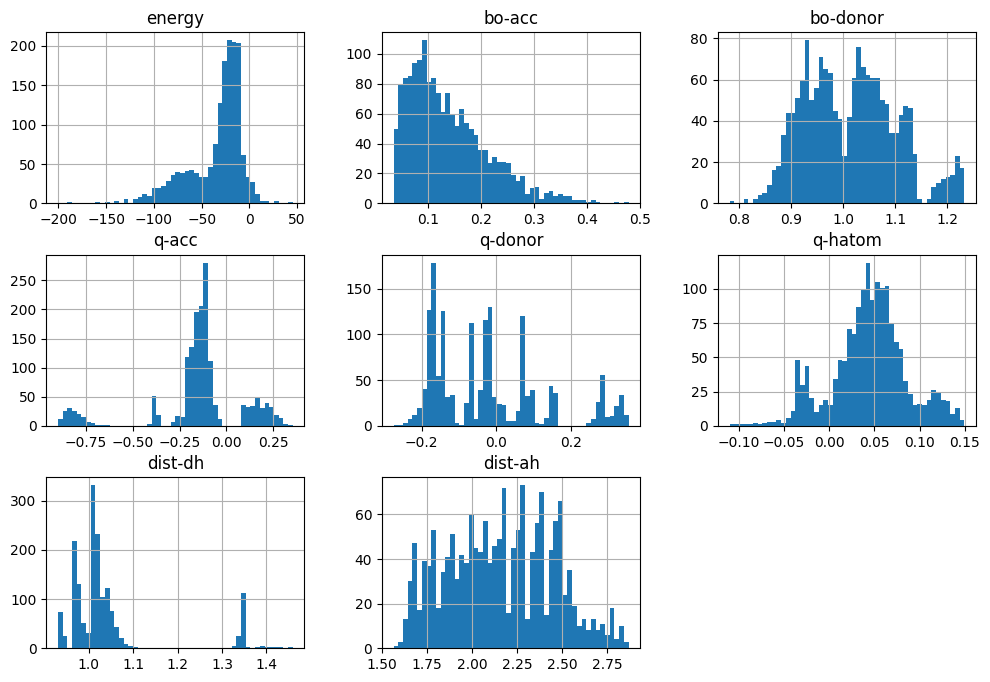

In [5]:
import matplotlib.pyplot as plt

hb_data.hist(bins=50, figsize=(12, 8))
plt.show()

## Split the data set into a train and test set

Before we will continue, we split our data set in a training and a test data set. This will provide a data set to estimate the generalization error of our final model. 

In [6]:
from sklearn.model_selection import train_test_split

# We set a fixed random number to provide reproducible results. 20% of the data is stored as test data and 80% as training data. 
train_set, test_set = train_test_split(hb_data, test_size=0.2, random_state=42)
print(f"Instances of training data set:{train_set.shape}")
print(f"Instances of test data set:{test_set.shape}")

Instances of training data set:(1310, 10)
Instances of test data set:(328, 10)


## Explore and visualize the data.

We can easily calculate the standard correlation coefficient between every pair of attributes to check for simple linear correlation:

In [7]:
# check for simple linear correlations
train_set_num = train_set.drop(['atomtype-acc','atomtype-don'], axis=1)
corr_matrix = train_set_num.corr()
print(corr_matrix["energy"])

energy      1.000000
bo-acc     -0.465641
bo-donor    0.518347
q-acc       0.541708
q-donor    -0.410503
q-hatom    -0.453727
dist-dh     0.095759
dist-ah     0.134798
Name: energy, dtype: float64


The correlation coefficient ranges from –1 to 1. A value close to 1 or -1 refers to a good linear correlation. 

A more detailed information can be obtained by a scatter plot from the pandas library.   

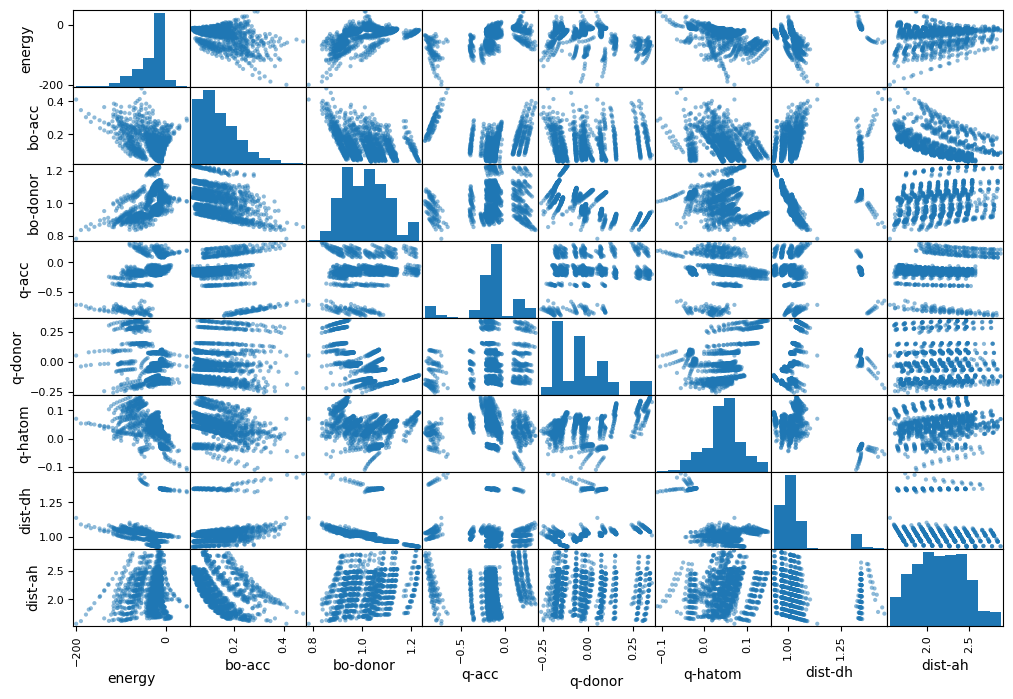

In [8]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

attributes = ["energy", "bo-acc", "bo-donor", "q-acc", "q-donor", "q-hatom", "dist-dh", "dist-ah"]
scatter_matrix(train_set[attributes], figsize=(12, 8))
plt.show()

We do not see a simple correlation for the energy. However, we see some regions in the other plots, for example q-acc vs. bo-acc. These might come from the atom types. To check this, we transform the element types to numbers first and make a plot on 3 variables subsequently: 

In [9]:
from sklearn.preprocessing import OrdinalEncoder

atomtype_acc_c = train_set[["atomtype-acc"]]

ordinal_encoder = OrdinalEncoder()
atomtype_acc_num = ordinal_encoder.fit_transform(atomtype_acc_c)

print("First five instances before transformation:")
print(atomtype_acc_c[:5])
print("\nFirst five instances after transformation:")
print(atomtype_acc_num[:5])

First five instances before transformation:
     atomtype-acc
63              S
1316            O
1018            S
1046            O
1149            O

First five instances after transformation:
[[4.]
 [3.]
 [4.]
 [3.]
 [3.]]


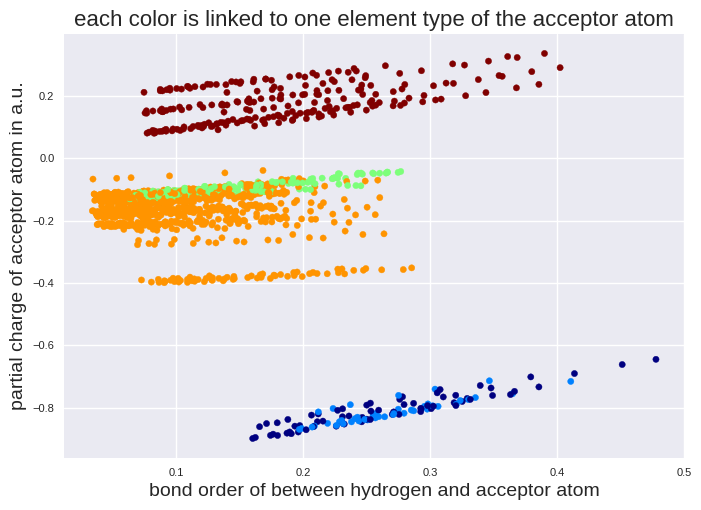

In [10]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

plt.scatter(train_set["bo-acc"], train_set["q-acc"], c=atomtype_acc_num, cmap=plt.cm.jet, s=20)
plt.title("each color is linked to one element type of the acceptor atom", fontsize=16)
plt.xlabel("bond order of between hydrogen and acceptor atom", fontsize=14)
plt.ylabel("partial charge of acceptor atom in a.u.", fontsize=14)
plt.tick_params(labelsize=8)

plt.show()

We check if we see a similar behavior for the energy.

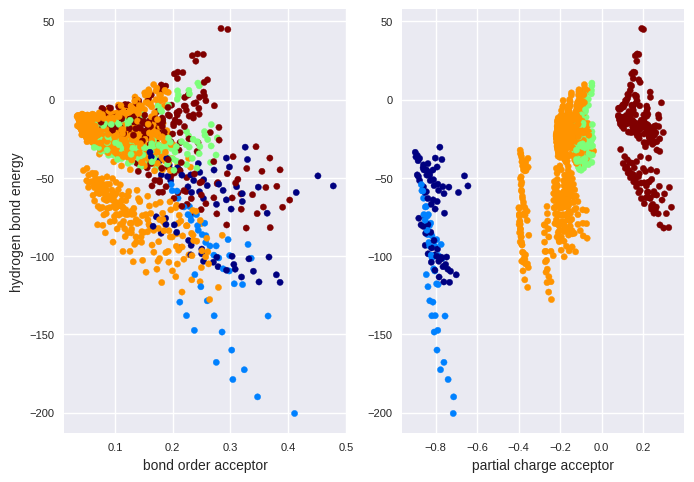

In [11]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(train_set["bo-acc"], train_set["energy"], c=atomtype_acc_num, cmap=plt.cm.jet, s=20)
ax[0].set_xlabel("bond order acceptor", fontsize=10)
ax[0].set_ylabel("hydrogen bond energy", fontsize=10)
ax[0].tick_params(labelsize=8)

ax[1].scatter(train_set["q-acc"], train_set["energy"], c=atomtype_acc_num, cmap=plt.cm.jet, s=20)
ax[1].set_xlabel("partial charge acceptor", fontsize=10)
ax[1].tick_params(labelsize=8)

plt.show()

There are regions where selected element types are strongly located. Thus, it seems reasonable to include element types in the regression model.

## Prepare the data for the machine learning algorithm

Before we train our first regression model, the data must be prepared for the machine learning approach. For example, we must transform the character values to numerical attributes as in the previous subsection. Furthermore, some algorithm are sensitive to the scaling of the input features, e.g. support vector regression or k-nearest neighbor regression. It might be also that some values in selected columns are missing. We will show some of these transformations first before we setup a pipeline which will make the data handling much easier. 

At first, we will pick all input data X from our training data by using drop from pandas to remove the energy column.

In [12]:
X_train = train_set.drop(['energy'], axis=1)

A common problem might be that your data is not complete. Selected values might be missing in some columns. You can remove these instances with the dropna feature of pandas: 

In [13]:
X_train.dropna(subset=["q-acc"], inplace=True)

Since our data set is complete, no instance will be removed from our example. 

You can also provide a guess by fillna of pandas. Here is a code example where each missing value is replaced by the average value of this column:

In [14]:
median = X_train["q-acc"].median() 
X_train.fillna({"q-acc": median}, inplace=True)

You have already seen in the previous section how to transform characters into numerical attributes:

In [15]:
from sklearn.preprocessing import OrdinalEncoder

atomtype_acc_c = train_set[["atomtype-acc"]]

ordinal_encoder = OrdinalEncoder()
atomtype_acc_num = ordinal_encoder.fit_transform(atomtype_acc_c)

print("First five instances before transformation:")
print(atomtype_acc_c[:5])
print("\nFirst five instances after transformation:")
print(atomtype_acc_num[:5])

First five instances before transformation:
     atomtype-acc
63              S
1316            O
1018            S
1046            O
1149            O

First five instances after transformation:
[[4.]
 [3.]
 [4.]
 [3.]
 [3.]]


You can check the numbers assigned to each element by following line:

In [16]:
ordinal_encoder.categories_

[array(['Cl', 'F', 'N', 'O', 'S'], dtype=object)]

Please note, it starts counting with 0. Passing this to a regression algorithm is not reasonable since it will assume that two nearby values are more similar than two distant values. This is not the case! 

A common solution is to create one binary attribute per category: The attribute for the element C is equal to 1 when the element is "C" and 0 otherwise. Scikit-learn provides a OneHotEncoder class to convert categorical values into one-hot vectors:

In [17]:
from sklearn.preprocessing import OneHotEncoder

atomtype_acc_c = train_set[["atomtype-acc"]]

cat_encoder = OneHotEncoder()
atomtype_acc_1hot = cat_encoder.fit_transform(atomtype_acc_c)

print("First five instances before transformation:")
print(atomtype_acc_c[:5])
print("\nFirst five instances after transformation:")
print(atomtype_acc_1hot[:5].toarray())

First five instances before transformation:
     atomtype-acc
63              S
1316            O
1018            S
1046            O
1149            O

First five instances after transformation:
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


You can get the categories similar as for the ordinal encoder:

In [18]:
cat_encoder.categories_

[array(['Cl', 'F', 'N', 'O', 'S'], dtype=object)]

Please note, the one-hot encoder will raise an exception when the trained model will be applied to an instance with an unknown category. 

Most machine learning approaches do not perform well on input features of different scales. Thus, it is important that you apply a feature scaling before passing the input features to the regression model. Scikit-Learn provides two approaches: 

In min-max scaling (also called normalization), the values are scaled in a given range (default is between 0 and 1). This is performed by subtracting the minimum value and dividing it by the difference between the minimum and the maximum. Please note, some models work best on selected scales. For example, neural networks work best with a zero-mean input. Thus, a range from -1 to 1 is desirable since the activation function of neural networks change strongest close to zero. A code example is given below: 

In [19]:
from sklearn.preprocessing import MinMaxScaler

X_train_num = train_set.drop(['energy','atomtype-acc','atomtype-don'], axis=1)

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_num_min_max = min_max_scaler.fit_transform(X_train_num)

print("First five instances before transformation:")
print(X_train_num[:5])
print("\nFirst five instances after transformation:")
print(X_train_num_min_max[:5])

First five instances before transformation:
      bo-acc  bo-donor     q-acc   q-donor   q-hatom   dist-dh   dist-ah
63    0.2549    1.1085  0.167554 -0.178104 -0.030259  0.965293  2.034707
1316  0.1725    0.8950 -0.261959  0.276786  0.108965  1.055615  1.844385
1018  0.2110    1.0962  0.205667 -0.182710 -0.008530  0.970337  2.129663
1046  0.1783    1.0630 -0.377025 -0.211999  0.049246  0.996096  1.903904
1149  0.0623    1.0837 -0.215193 -0.064738  0.078079  0.972071  2.327929

First five instances after transformation:
[[-0.0056319   0.4504764   0.72635861 -0.73536865 -0.38518884 -0.86668117
  -0.27765376]
 [-0.37688669 -0.49567915  0.03100271  0.74724875  0.68813457 -0.52531492
  -0.56979647]
 [-0.20342419  0.39596721  0.78806129 -0.75038093 -0.21767286 -0.84761657
  -0.1318979 ]
 [-0.35075467  0.24883669 -0.15528228 -0.84584221  0.22774124 -0.75026229
  -0.47843542]
 [-0.87339491  0.34057168  0.10671407 -0.36587624  0.45002428 -0.84106274
   0.17243787]]


Standardization is an alternative approach. First, it subtracts the mean value. Thus, the mean value is shifted to zero. Subsequently, the results are divided by the standard deviation. Thus, standardization is not restricted to values within a specific range and much less affected by outliers. You can setup this with following code:

In [20]:
from sklearn.preprocessing import StandardScaler

X_train_num = train_set.drop(['energy','atomtype-acc','atomtype-don'], axis=1)

std_scaler = StandardScaler()
X_train_num_std = std_scaler.fit_transform(X_train_num)

print("First five instances before transformation:")
print(X_train_num[:5])
print("\nFirst five instances after transformation:")
print(X_train_num_std[:5])

First five instances before transformation:
      bo-acc  bo-donor     q-acc   q-donor   q-hatom   dist-dh   dist-ah
63    0.2549    1.1085  0.167554 -0.178104 -0.030259  0.965293  2.034707
1316  0.1725    0.8950 -0.261959  0.276786  0.108965  1.055615  1.844385
1018  0.2110    1.0962  0.205667 -0.182710 -0.008530  0.970337  2.129663
1046  0.1783    1.0630 -0.377025 -0.211999  0.049246  0.996096  1.903904
1149  0.0623    1.0837 -0.215193 -0.064738  0.078079  0.972071  2.327929

First five instances after transformation:
[[ 1.5289407   1.08558958  1.30277591 -1.04442968 -1.7550715  -0.69528915
  -0.40588825]
 [ 0.4406232  -1.34253292 -0.43263547  1.96015514  1.51792787  0.11637256
  -1.0615082 ]
 [ 0.94912106  0.94570243  1.4567683  -1.07485268 -1.24424719 -0.64995954
  -0.07878632]
 [ 0.51722807  0.56812085 -0.89755003 -1.26830886  0.11400147 -0.41848162
  -0.85647783]
 [-1.01486938  0.80354069 -0.24368135 -0.29563819  0.79183281 -0.63437658
   0.60419701]]


Please note, both approaches are not suited for data with a heavy tail. Most data will be still in a small range after the transformation. Thus, you should shrink the heavy tail before scaling. 

Scikit-Learn provides the possibility to setup a pipeline for the transformations. This will make it much easier to execute everything correctly, for example to run the fitted model on the test data set. Below is the example for a standard scaling and a one-hot encoder.

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np

#This line will get solely the column energy from the training data set.
y_train = train_set['energy']
#This line will remove solely the column energy from the training data set.
X_train = train_set.drop(['energy'], axis=1)

num_pipeline = make_pipeline(StandardScaler())
# If you want to give a specific name your pipeline, you can also use following two lines of code:
# from sklearn.pipeline import Pipeline
# num_pipeline = Pipeline([("scaling", StandardScaler()),])
# If you want to employ min-max scaling, use following two lines:
#from sklearn.preprocessing import MinMaxScaler
#num_pipeline = make_pipeline(MinMaxScaler(feature_range=(-1, 1)))
cat_pipeline = make_pipeline(OneHotEncoder()) 

# The num_pipeline is solely applied to numerical values while cat_pipelines is used on characters
preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object))])
# You can also apply a transformer solely to selected features:
#cat_attribs = ["atomtype-acc"]
#preprocessing = ColumnTransformer([("cat-acc",cat_pipeline, cat_attribs)],remainder='passthrough')

X_train_prepared = preprocessing.fit_transform(X_train)

print("These are the first 5 instances of our input features after the pipeline:")
print(X_train_prepared[:5])

These are the first 5 instances of our input features after the pipeline:
[[ 1.5289407   1.08558958  1.30277591 -1.04442968 -1.7550715  -0.69528915
  -0.40588825  0.          0.          0.          0.          1.
   0.          0.          1.          0.        ]
 [ 0.4406232  -1.34253292 -0.43263547  1.96015514  1.51792787  0.11637256
  -1.0615082   0.          0.          0.          1.          0.
   0.          1.          0.          0.        ]
 [ 0.94912106  0.94570243  1.4567683  -1.07485268 -1.24424719 -0.64995954
  -0.07878632  0.          0.          0.          0.          1.
   0.          0.          1.          0.        ]
 [ 0.51722807  0.56812085 -0.89755003 -1.26830886  0.11400147 -0.41848162
  -0.85647783  0.          0.          0.          1.          0.
   0.          0.          1.          0.        ]
 [-1.01486938  0.80354069 -0.24368135 -0.29563819  0.79183281 -0.63437658
   0.60419701  0.          0.          0.          1.          0.
   0.          0.     

Thus, our data set is now ready for training our first regression model. Please note, never use fit() or fit_transform() on anything else then the training data! You can use transform() on any data. You can get the column names of your pipeline by using pandas:

In [22]:
import pandas as pd

pd.DataFrame(X_train_prepared, columns=preprocessing.get_feature_names_out())

,num__bo-acc,num__bo-donor,num__q-acc,num__q-donor,num__q-hatom,num__dist-dh,num__dist-ah,cat__atomtype-acc_Cl,cat__atomtype-acc_F,cat__atomtype-acc_N,cat__atomtype-acc_O,cat__atomtype-acc_S,cat__atomtype-don_F,cat__atomtype-don_N,cat__atomtype-don_O,cat__atomtype-don_S
0,1.528941,1.085590,1.302776,-1.044430,-1.755071,-0.695289,-0.405888,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.440623,-1.342533,-0.432635,1.960155,1.517928,0.116373,-1.061508,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.949121,0.945702,1.456768,-1.074853,-1.244247,-0.649960,-0.078786,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.517228,0.568121,-0.897550,-1.268309,0.114001,-0.418482,-0.856478,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-1.014869,0.803541,-0.243681,-0.295638,0.791833,-0.634377,0.604197,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0.699495,-1.220842,1.126638,1.097076,0.425000,-0.107656,1.091242,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1306,0.900252,-0.223436,-2.857524,-1.191333,-0.740334,-0.023279,0.724262,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1307,-0.777130,0.341799,0.155201,-0.975407,-0.225631,-0.235411,0.106780,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1308,0.020617,0.327015,-0.032606,0.012793,-1.577556,2.758347,-1.385322,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Select a model, train it and fine tuning

### Linear Regression

We will start with a linear regression since this approach was often used in the literature to predict the hydrogen bond energy. It has following form: 
\begin{equation}
\hat{y} = \mathbf{w}\cdot\mathbf{x} = \mathbf{w^T}\mathbf{x}
\end{equation}
$\mathbf{x}$ is the feature vector of an instance and contains $x_0$ to $x_m$ where $x_0=1$. $w$ is the parameter vector containing the bias term $w_0$ and the feature weights $w_1$ to $w_m$. 

We can define a cost function $J$ which should be minimized during training the model. Scikit-Learn used the mean square error (MSE) (also called L2 loss) for the linear regression:
\begin{equation}
J(\mathbf{w})=\underbrace{\frac{1}{m}\sum\limits_{i=1}^m\left(\mathbf{w}^T\mathbf{x}^{(i)}-y^{(i)}\right)^2}_{MSE}
\end{equation}
An alternative would be the mean absolute error (also called L1 loss). The implementation in Scikit-Learn to minimize the MSE for a linear regression scales linear with the number of instances $m$ and cubic with the number of input features $n$. You can use the stochastic gradient descent regressor in Scikit-Learn (SGDRegressor) to fit a linear regression model for data sets with a large number of input features. The SGDRegressor scales linear with the number of instances and features.

We can easily setup a pipeline for a linear regression with Scikit-Learn:   

In [23]:
from sklearn.linear_model import LinearRegression

# The lines below were added if you would like to run this cell directly after generating a test data set.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np

y_train = train_set['energy']
X_train = train_set.drop(['energy'], axis=1)

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder()) 

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object))])
# end of obsolete lines if all previous cells were run.

# fit_intercepts determines if the bias term is set to zero (False) or will be fitted (True).
model_linr = make_pipeline(preprocessing, LinearRegression(fit_intercept=True))
model_linr.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


We can now use our model to predict the hydrogen bond energy. In the example below, we use the instances of our training data:

In [24]:
HB_predict = model_linr.predict(X_train)
HB_predict[:5].round(2)

array([  1.88, -91.99,  -4.82, -62.76, -38.48])

We compare it to the label of our training data:

In [25]:
y_train[:5].round(2)

63        2.25
1316   -108.41
1018    -14.47
1046    -65.69
1149    -27.65
Name: energy, dtype: float64

It does not look so good. Let us do the comparison in a more systematic way. Scikit-Learn provides diverse options. A possibility is the coefficient of determination ($R^2$) which is given by: 
\begin{equation}
R^2 = 1-\frac{\sum\limits_{i=1}^m\left(y^{(i)}-h(\mathbf{x}^{(i)})\right)^2}{\sum\limits_{i=1}^m\left(y^{(i)}-\overline{y}\right)^2}
\end{equation}
$\overline{y}$ is the average value of $y$. A determination coefficient close to 1 would be desirable. More examples to evaluate the model are given below: 

In [26]:
from sklearn.metrics import r2_score
lin_r2 = r2_score(y_train, HB_predict)
print("The model has a coefficient of determination of %0.2f on the training data set\n" % lin_r2)

from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(y_train, HB_predict)
print("The model has a mean absolute error of %0.2f kJ/mol on the training data set\n" % lin_mae)

from sklearn.metrics import mean_absolute_percentage_error
lin_maep = mean_absolute_percentage_error(y_train, HB_predict)
print("The model has a mean absolute percentage error of %0.3f on the training data set\n" % lin_maep)

from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_train, HB_predict)
print("The model has a mean squared error of %0.2f kJ/mol on the training data set\n" % lin_mse)

from sklearn.metrics import root_mean_squared_error
lin_rmse = root_mean_squared_error(y_train, HB_predict)
print("The model has a root mean squared error of %0.2f kJ/mol on the training data set\n" % lin_rmse)

The model has a coefficient of determination of 0.90 on the training data set

The model has a mean absolute error of 6.77 kJ/mol on the training data set

The model has a mean absolute percentage error of 0.558 on the training data set

The model has a mean squared error of 87.06 kJ/mol on the training data set

The model has a root mean squared error of 9.33 kJ/mol on the training data set



The evaluation above has a drawback: All values are compared for data which was used during the training. Thus, we have no chance to detect overfitting! It would be much better to use our test data set for validation. However, we would like to compare different approaches subsequently. If we take for validation the test data set now, it will affect our final choice. Thus, we do not have a good proof for the accuracy of our model on unseen data. We want to use the test data set solely on our final model! 
To solve this problem, we can split our training data set again and use only a part of it for training a model. The other part is used to validate the model on unseen data. In practice, one uses n-fold cross validation. It splits the training data set of n subregions of similar size. Subsequently, one subregion is used vor validation while the rest is used to train the model. This is repeated for all subregions. Below is the code of a 5-fold cross-validation of our linear regression model:         

In [27]:
from sklearn.model_selection import cross_val_score

scores = -cross_val_score(model_linr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

print(f"Root mean square error of each validation in kJ/mol:\n{scores}\n")
print("This is an average root mean square deviation of %0.2f kJ/mol with a standard deviation of %0.2f kJ/mol\n" % (scores.mean(), scores.std()))

Root mean square error of each validation in kJ/mol:
[10.23310927 10.13593914  8.86243621  9.07401867  8.99106553]

This is an average root mean square deviation of 9.46 kJ/mol with a standard deviation of 0.60 kJ/mol



The comparison of the 5 models allows us to estimate how strong the fit depends on the provided data. 

### Polynomial Regression

We will carry out a polynomial regression next. The PolynomialFeature function allows us to transform our training data by adding the square (second degree polynomial) of each feature as well as the product of two features to our input features. Subsequently, we can carry out a linear regression on the transformed features to obtain a second degree polynomial regression model.    

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# The lines below were added if you would like to run this cell directly after generating a test data set.
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np

y_train = train_set['energy']
X_train = train_set.drop(['energy'], axis=1)
# end of obsolete lines if all previous cells were run.

num_pipeline = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder())

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])

model_polyr = make_pipeline(preprocessing, LinearRegression())

scores = -cross_val_score(model_polyr, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)

print(f"Root mean square error of each validation in kJ/mol:\n{scores}\n")
print("This is an average root mean square deviation of %0.2f kJ/mol with a standard deviation of %0.2f kJ/mol\n" % (scores.mean(), scores.std()))

Root mean square error of each validation in kJ/mol:
[5.08523546 5.38320832 4.06508922 4.16875129 4.19829657]

This is an average root mean square deviation of 4.58 kJ/mol with a standard deviation of 0.54 kJ/mol



We have already improved our fit compared to the linear regression model. We can test different degrees of polynomials with the code above. However, there is a more elegant way to train machine learning models with different hyperparameters and identify the best model. One option is a grid search which will carry out a cross-validation for all combinations of provided hyperparameters. We will train solely polynomials up to the 5th degree. Please note, the degree $d$ in combination with an array of $n$ input features will be transformed into an array containing $\frac{(n + d)!}{d!n!}$ features. Thus, the 5th degree polynomial of our example has already 330 input features for the numerical input values and 9 features representing the element types.

At first, we must get the correct name of the hyperparameter for our grid search code. This can be done by following line: 

In [29]:
model_polyr.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'columntransformer', 'linearregression', 'columntransformer__force_int_remainder_cols', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__num', 'columntransformer__cat', 'columntransformer__num__memory', 'columntransformer__num__steps', 'columntransformer__num__transform_input', 'columntransformer__num__verbose', 'columntransformer__num__polynomialfeatures', 'columntransformer__num__standardscaler', 'columntransformer__num__polynomialfeatures__degree', 'columntransformer__num__polynomialfeatures__include_bias', 'columntransformer__num__polynomialfeatures__interaction_only', 'columntransformer__num__polynomialfeatures__order', 'columntransformer__num__standardscaler__copy', 'columntransformer__num__standard

We know that our hyperparameter of PolynomialFeatures is called degree. Furthermore, we setup a pipeline called "num" for the numeric values. This is part of the ColumnTransformer. Therefore, it should be "columntransformer_num_polynomialfeatures_degree" which we find also in the list above. This allows us to setup a grid search:  

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'columntransformer__num__polynomialfeatures__degree': [2,3,4,5],
              }]
grid_search = GridSearchCV(model_polyr, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

cv_hyperpara = pd.DataFrame(grid_search.cv_results_)
cv_hyperpara.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_hyperpara.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__num__polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.016286,0.004684,0.003972,0.000216,3,{'columntransformer__num__polynomialfeatures__...,-3.617144,-3.299042,-3.068542,-2.780995,-4.847873,-3.522719,0.717135,1
0,0.052444,0.077288,0.004157,0.000137,2,{'columntransformer__num__polynomialfeatures__...,-5.085235,-5.383208,-4.065089,-4.168751,-4.198297,-4.580116,0.544125,2
2,0.080163,0.008022,0.010301,0.003171,4,{'columntransformer__num__polynomialfeatures__...,-12.146789,-10.055317,-1.663481,-6.152934,-10.227071,-8.049119,3.739815,3
3,0.214400,0.046486,0.007759,0.001551,5,{'columntransformer__num__polynomialfeatures__...,-426.741072,-118.167853,-14.758106,-40.001822,-250.167813,-169.967333,152.334497,4


As you can see from the table above, the model with a third degree polynomial works best. A higher degree polynomial shows poorer performance. One reason might be overfitting. We can check this by a learning curve for which a cross-validation is carried out on data sets of different sizes.  

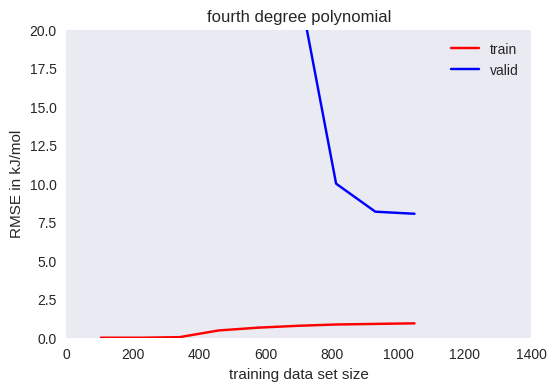

In [31]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Lines selecting our model for which we want to obtain the learning curve. We choose a fourth degree polynomial.
num_pipeline = make_pipeline(PolynomialFeatures(degree=4, include_bias=True),StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder())

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])

model_polyr = make_pipeline(preprocessing, LinearRegression())

# new code
train_sizes, train_scores, valid_scores = learning_curve(
    model_polyr, X_train, y_train, cv=5,
    scoring="neg_root_mean_squared_error",train_sizes=np.linspace(0.1, 1.0, 9))

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", label="train")
plt.plot(train_sizes, valid_errors, "b-+", label="valid")
plt.legend(loc="upper right")
plt.xlabel("training data set size")
plt.ylabel("RMSE in kJ/mol")
plt.title("fourth degree polynomial")
plt.grid()
plt.axis([0, 1400, 0, 20])
plt.show()

The red line uses the training data to determine the root mean square error (RMSE). The blue line uses the validation set. Clearly visible is the large gab between both RMSE indicating overfitting. Let us compare it to the second and third degree polynomial. 

<center><img src="img/learning-curve-polynom.png" style="width: 1000px;"/></center>

Both lines converge quickly for the second degree polynomial. The same behavior is visible for the third degree polynomial starting from about 800 data points for the training data set size. Thus, we can expect that increasing the data set will not improve both models. Furthermore, the second degree polynomial is underfitted compared to the third degree polynomial.

### Regularized linear models

The question arises: Can we get a better fourth degree polynomial fit if we apply selected constrains to our weights during fitting? This can be done by regularized linear regression models where we will introduce three examples in more detail in the following.

The first example is called ridge regression. The cost function $J$ is extended as follow:
\begin{equation}
J(\mathbf{w})=\underbrace{\frac{1}{m}\sum\limits_{i=1}^m\left(\mathbf{w}^T\mathbf{x}^{(i)}-y^{(i)}\right)^2}_{MSE}+\underbrace{\frac{\alpha}{m}\sum\limits_{i=1}^n w_i^2}_{l2~norm}
\end{equation}

The extension represents the l2 norm of the feature weights from 1 to $n$. The bias term is not regularized since the sum over the features $n$ starts at 1. Increasing the hyperparameter $α$ leads to flatter predictions. Thus, the model’s variance is reduced. Let us check if we can get a better fourth degree polynomial by applying this technique:

In [32]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

# The lines below were added if you would like to run this cell directly after generating a test data set.
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import GridSearchCV
import numpy as np

y_train = train_set['energy']
X_train = train_set.drop(['energy'], axis=1)
# end of obsolete lines if all previous cells were run.

num_pipeline = make_pipeline(PolynomialFeatures(degree=4, include_bias=True),StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False))

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])

model_ridge = make_pipeline(preprocessing, Ridge(random_state=42))

param_grid = [{'ridge__alpha': [0.001,0.005,0.01,0.05,0.1,0.5,1],
              }]
grid_search = GridSearchCV(model_ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

cv_hyperpara = pd.DataFrame(grid_search.cv_results_)
cv_hyperpara.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_hyperpara.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.339300,0.178291,0.012109,0.014573,0.001,{'ridge__alpha': 0.001},-2.474718,-3.311104,-1.991025,-1.705258,-2.041419,-2.304705,0.560142,1
1,0.333195,0.259525,0.010708,0.004768,0.005,{'ridge__alpha': 0.005},-2.741799,-2.957761,-2.365332,-1.944842,-2.306915,-2.463330,0.353527,2
2,0.339058,0.238155,0.010524,0.003885,0.010,{'ridge__alpha': 0.01},-2.922780,-2.943772,-2.528130,-2.102223,-2.319368,-2.563254,0.330852,3
3,0.209195,0.062691,0.006438,0.000295,0.050,{'ridge__alpha': 0.05},-3.502702,-3.000132,-2.856661,-2.557886,-2.503420,-2.884160,0.360060,4
4,0.234164,0.102149,0.011133,0.007437,0.100,{'ridge__alpha': 0.1},-3.785567,-3.064985,-2.977414,-2.743374,-2.615944,-3.037457,0.406986,5


The best model with $\alpha=0.001$ has an average RMSE of 2.30 kJ/mol. This is better than our third degree polynomial (RMSE: 3.52 kJ/mol). 

Let us try lasso regression next which extends the cost function as follow:
\begin{equation}
J(\mathbf{w})=\underbrace{\frac{1}{m}\sum\limits_{i=1}^m\left(\mathbf{w}^T\mathbf{x}^{(i)}-y^{(i)}\right)^2}_{MSE}+\underbrace{2\alpha\sum\limits_{i=1}^n |w_i|}_{l1~norm}
\end{equation}
An important characteristic of lasso regression is that it tends to eliminate the weights of the least important features.

In [33]:
from sklearn.linear_model import Lasso

num_pipeline = make_pipeline(PolynomialFeatures(degree=4, include_bias=True),StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False))

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])

model_lasso = make_pipeline(preprocessing, Lasso(tol=0.001,max_iter=10000,random_state=42))

param_grid = [{'lasso__alpha': [0.01,0.05,0.1,0.5,1],
              }]
grid_search = GridSearchCV(model_lasso, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

cv_hyperpara = pd.DataFrame(grid_search.cv_results_)
cv_hyperpara.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_hyperpara.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.157586,0.211076,0.006215,0.000286,0.01,{'lasso__alpha': 0.01},-4.672010,-3.804662,-3.465088,-3.330916,-3.395455,-3.733626,0.496842,1
1,0.230627,0.075719,0.006133,0.000178,0.05,{'lasso__alpha': 0.05},-5.462308,-5.585104,-4.147108,-4.482182,-4.149371,-4.765214,0.632390,2
2,0.167969,0.077361,0.006214,0.000551,0.10,{'lasso__alpha': 0.1},-5.877349,-6.386720,-4.705775,-5.037777,-4.732187,-5.347962,0.670383,3
3,0.045776,0.004455,0.005939,0.000194,0.50,{'lasso__alpha': 0.5},-7.852872,-8.679819,-7.103944,-7.422412,-7.022961,-7.616402,0.606497,4
4,0.039817,0.007116,0.006030,0.000323,1.00,{'lasso__alpha': 1},-8.326920,-9.490296,-7.606208,-8.001640,-7.512350,-8.187483,0.713441,5


The best set of hyperparameters has on average a RMSE of 3.73 kJ/mol which is not as good as the third degree polynomial. 

Elastic net is the combination of both previous regularization techniques. It has two hyperparameters: $\alpha$ and the l1-ratio. The l1-ratio determines the weight of the l1 and l2 norm and can be between 0 and 1. In the example below, we will employ additionally an alternative to the grid search. RandomizedSearchCV will train models only for a number of randomly selected combinations of hyperparameters. Thus, it is efficient for a large number of hyperparameters but it might miss the optimal values.

In [34]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

num_pipeline = make_pipeline(PolynomialFeatures(degree=4, include_bias=True),StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False))

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])

model_elasticnet = make_pipeline(preprocessing, ElasticNet(max_iter=10000,tol=0.01,random_state=42))

param_distribs = {'elasticnet__alpha': [0.01,0.05,0.1,0.5,1],
                  'elasticnet__l1_ratio': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]}

rnd_search = RandomizedSearchCV(model_elasticnet, param_distributions=param_distribs, n_iter=20, cv=5,
                                scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

cv_hyperpara = pd.DataFrame(rnd_search.cv_results_)
cv_hyperpara.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_hyperpara.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_elasticnet__l1_ratio,param_elasticnet__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.181694,0.057098,0.012742,0.011751,0.4,0.01,"{'elasticnet__l1_ratio': 0.4, 'elasticnet__alp...",-5.132070,-4.486064,-3.815053,-3.763908,-3.765210,-4.192461,0.543637,1
6,0.085291,0.023795,0.011299,0.009637,0.5,0.01,"{'elasticnet__l1_ratio': 0.5, 'elasticnet__alp...",-5.144582,-4.374075,-3.841969,-3.824129,-3.791464,-4.195244,0.521304,2
10,0.077974,0.012468,0.008518,0.003152,0.7,0.01,"{'elasticnet__l1_ratio': 0.7, 'elasticnet__alp...",-5.256995,-4.363637,-3.873677,-3.893520,-3.835811,-4.244728,0.541676,3
8,0.045074,0.007659,0.006808,0.001358,0.9,0.01,"{'elasticnet__l1_ratio': 0.9, 'elasticnet__alp...",-5.325776,-4.433316,-3.929402,-3.976640,-3.888517,-4.310730,0.544176,4
14,0.038555,0.002647,0.005929,0.000185,0.9,0.05,"{'elasticnet__l1_ratio': 0.9, 'elasticnet__alp...",-5.629445,-5.646073,-4.293566,-4.542854,-4.297907,-4.881969,0.623686,5


The best set of hyperparameters has an average RMSE of 4.19 kJ/mol. Thus, the combination of both regularization techniques did not result in a better model than applying solely ridge regression.   

### Random Forest Regression

Random forests regression is an ensemble approach. It is composed of several decision trees trained on different training data. We will train a very simple decision tree to illustrate the concept. Only one input feature is passed to the model, the charge of the acceptor atom q-acc.  

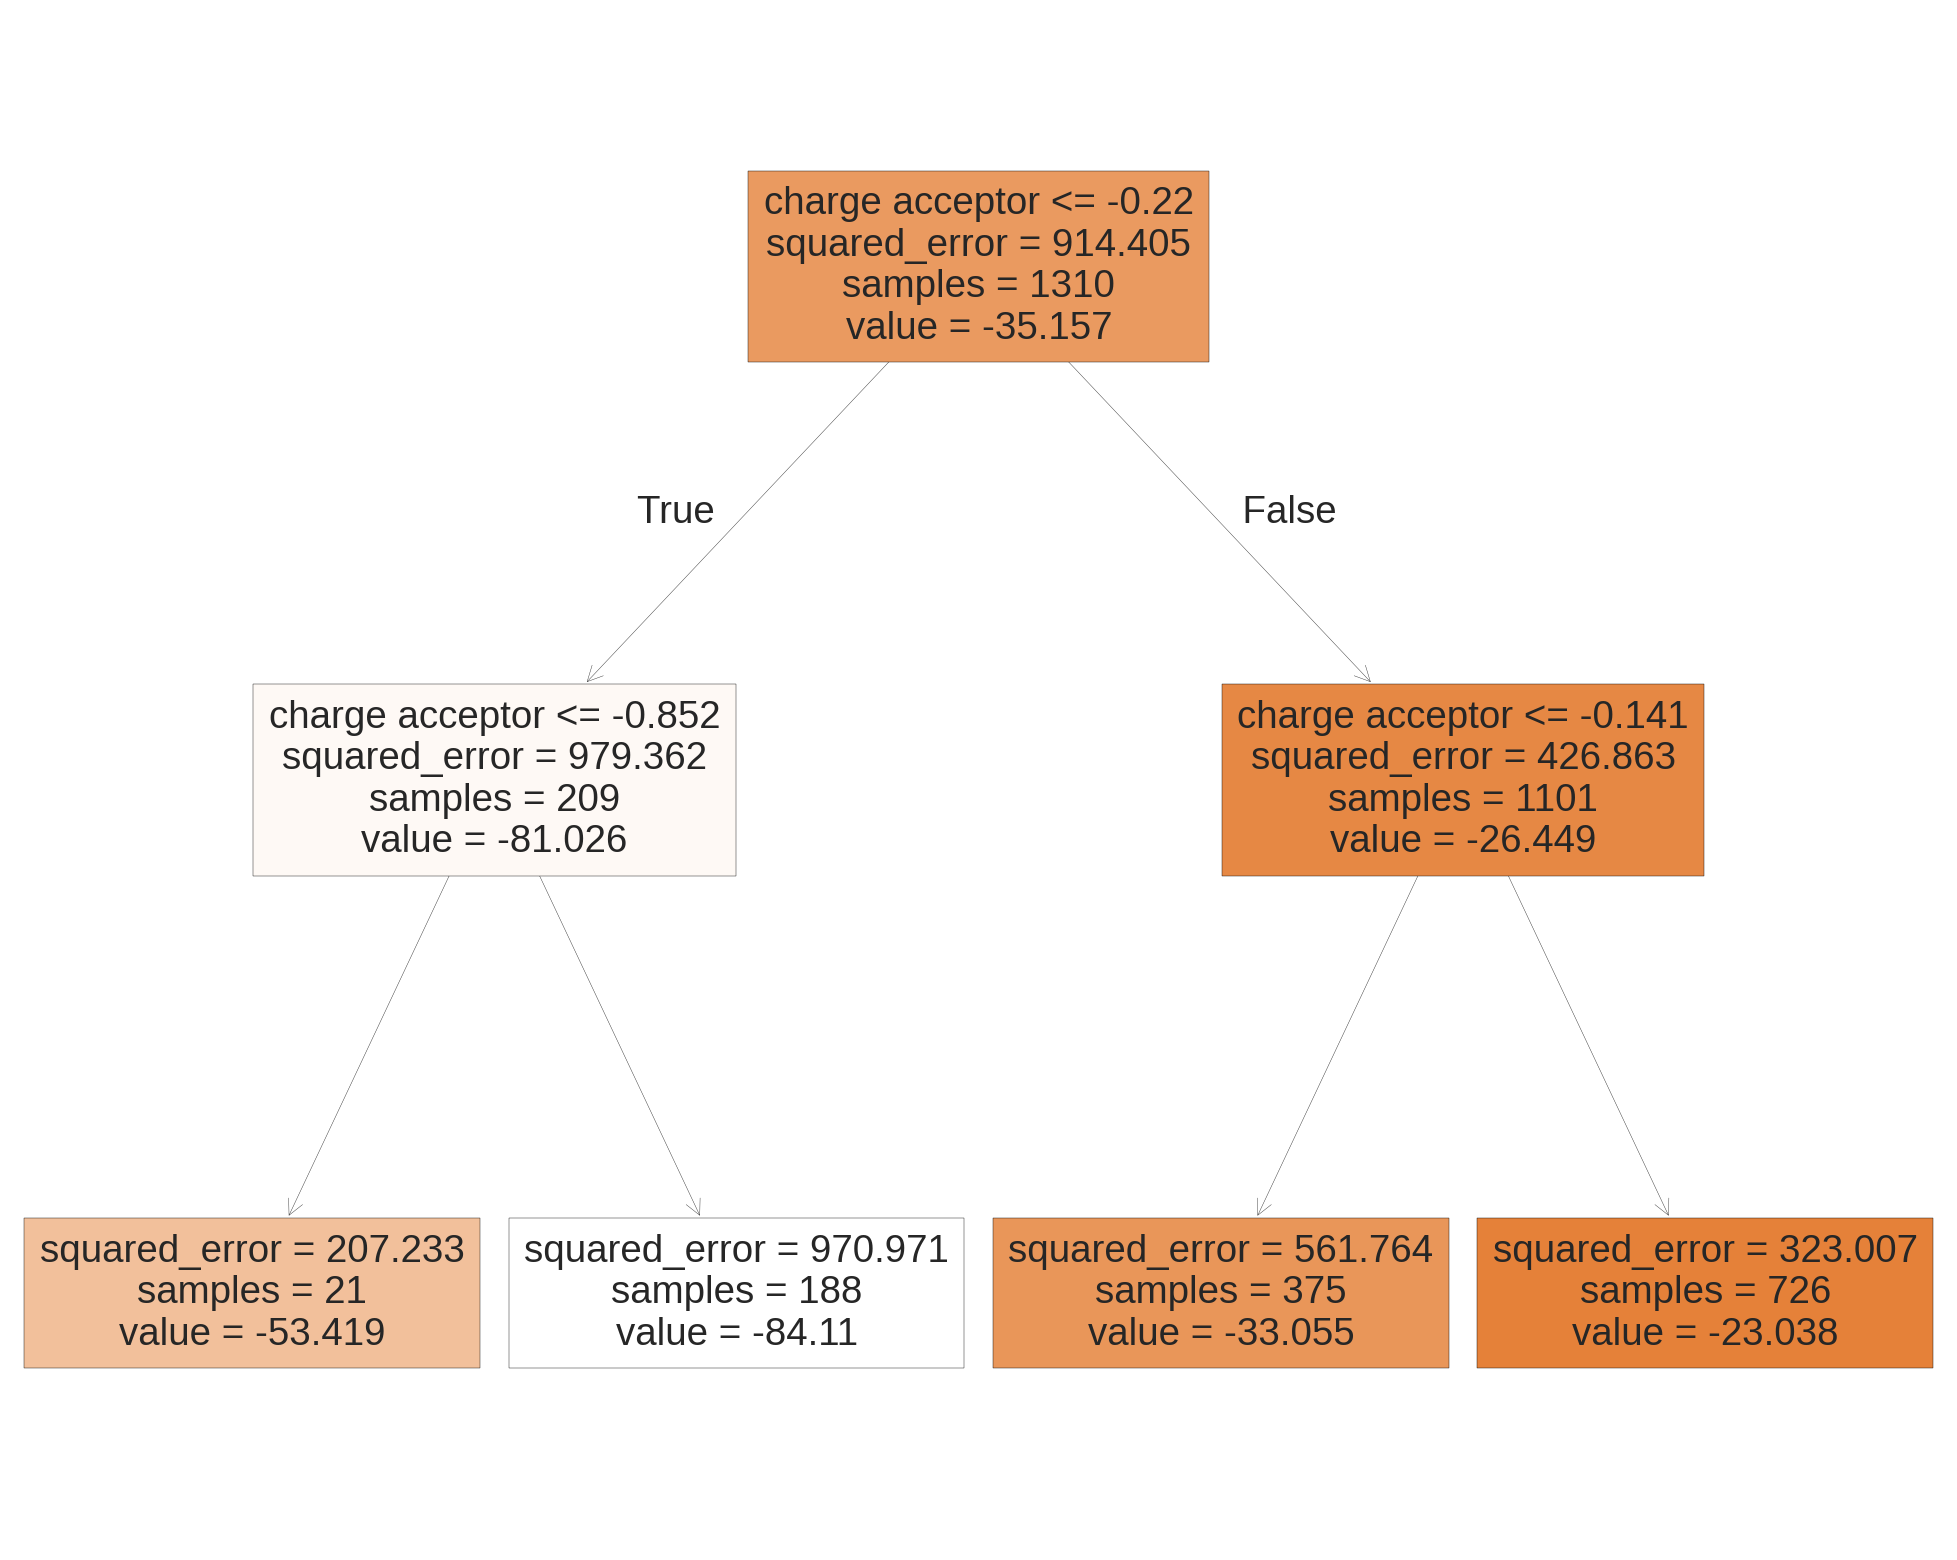

In [35]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import tree

y_train = train_set['energy']
# We use two brackets on the next line to make a matrix instead of a vector.  
X_train = train_set[['q-acc']]
 
model_tree = DecisionTreeRegressor(max_depth=2, criterion='squared_error', random_state=42)

model_tree.fit(X_train,y_train)

fig = plt.figure(figsize=(25,20))
treeplot = tree.plot_tree(model_tree,
                   feature_names=['charge acceptor'],
                   filled=True)

The first box is the root node. All training data ("samples = 1310") is on this node. The data is split into two subsets resulting in the two nodes below. The left one consists of 209 samples, the right one of 1101 samples. A hydrogen bond energy of -81.206 kJ/mol (second row, left node) is predicted for an input value less/equal than -0.22 a.u. while it is -26.449 kJ/mol (second row, right node) for larger values. A mean squared error (MSE) of 914.405 kJ/mol (see root node) is obtained for this prediction based on the samples of the root node. The partial charge of -0.22 a.u. was selected since it minimizes the MSE. The subsequent node act similar but uses only the data passed to the this node to optimize the MSE. The bottom boxes are the leaf nodes which are the final prediction of the model.   
As you can imagine from this example, decision trees are very flexible regression models. They are also computationally efficient and can be used to train models with numerous features and instances. However, they are bad in interpolating and extrapolating since they show a stepwise fit. Furthermore, they strongly depend on the training data. To fix the dependency on the training data, random forests are an ensemble of decision trees trained on different random subsets of the training set. Commonly bagging is employed where instances are taken randomly with replacement from the training data, e.g. the new data set can contain the same instance of the original data set several times. Nonetheless, random forests show still poor performance for inter- and extrapolation due to the stepwise predictions.        

In [36]:
from sklearn.ensemble import RandomForestRegressor

# The lines below were added if you would like to run this cell directly after generating a test data set.
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np

y_train = train_set['energy']
X_train = train_set.drop(['energy'], axis=1)
# end of obsolete lines if all previous cells were run.


num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False))

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])
 
model_forest = make_pipeline(preprocessing, RandomForestRegressor(min_samples_split=2, n_estimators=100, 
                                                                      criterion='squared_error', random_state=42))

scores = -cross_val_score(model_forest, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

print(f"Root mean square error of each validation in kJ/mol:\n{scores}\n")
print("This is an average root mean square deviation of %0.2f kJ/mol with a standard deviation of %0.2f kJ/mol\n" % (scores.mean(), scores.std()))

Root mean square error of each validation in kJ/mol:
[6.20039389 4.36108597 4.11073983 3.95990658 3.87353018]

This is an average root mean square deviation of 4.50 kJ/mol with a standard deviation of 0.87 kJ/mol



Thus, this model is not as good as the polynomial models for our example. The hyperparameter criterion sets the function to measure the quality of a split. The minimum number of samples required to split a node is set by min_samples_split. n_estimators sets the numbers of trees in the forest.   

Random forests have the advantage that they can determine the relative importance of each feature easily. Scikit-learn does this by checking how much the tree nodes that use that feature reduce impurity on average, across all trees in the forest. This can be done as follow: 

[(np.float64(0.3840784862281904), 'num__q-acc'),
 (np.float64(0.25286800830658557), 'num__bo-donor'),
 (np.float64(0.18254105585465052), 'num__q-donor'),
 (np.float64(0.07477051640632408), 'num__q-hatom'),
 (np.float64(0.024520316925131888), 'num__dist-ah'),
 (np.float64(0.023382116265997534), 'num__dist-dh'),
 (np.float64(0.022435614588414907), 'cat__atomtype-acc_F'),
 (np.float64(0.020486101713881696), 'num__bo-acc'),
 (np.float64(0.005285003523203828), 'cat__atomtype-don_O'),
 (np.float64(0.0027381601587412444), 'cat__atomtype-don_N'),
 (np.float64(0.0027354143627047792), 'cat__atomtype-acc_N'),
 (np.float64(0.0023563255542269883), 'cat__atomtype-don_S'),
 (np.float64(0.0010909237815835448), 'cat__atomtype-acc_O'),
 (np.float64(0.00031018610075453764), 'cat__atomtype-acc_S'),
 (np.float64(0.00025665224755813215), 'cat__atomtype-don_F'),
 (np.float64(0.00014511798205036697), 'cat__atomtype-acc_Cl')]

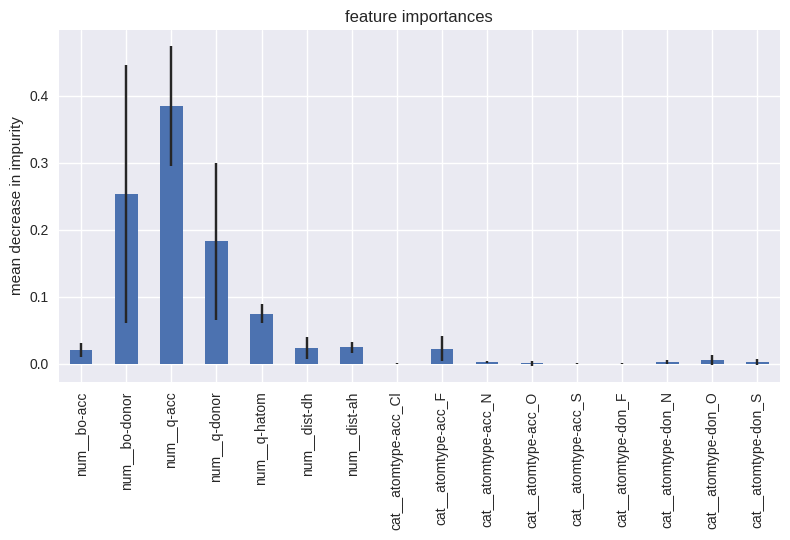

In [37]:
model_forest.fit(X_train, y_train)

feature_importances = model_forest['randomforestregressor'].feature_importances_
std = np.std([tree.feature_importances_ for tree in model_forest['randomforestregressor'].estimators_], axis=0)

forest_importances = pd.Series(feature_importances, index=model_forest['columntransformer'].get_feature_names_out())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("feature importances")
ax.set_ylabel("mean decrease in impurity")
fig.tight_layout()

sorted(zip(feature_importances, model_forest['columntransformer'].get_feature_names_out()),reverse=True)

Please note, feature analysis based on mean decrease in impurity has a bias toward high-cardinality features, e.g. features with many unique categories or levels. Nonetheless, it is very handy to get a quick understanding of what features matter. Thus, it is helpful if you need to perform feature selection.

### Support Vector Regression

Support vector regression (SVR) has two central concepts. 

SVR tries to fit as many instances as possible on a linear street. The width of the street is controlled by the hyperparameter $\epsilon$. Thus, instances off the street will be minimized. Adding more training instances on the street will not affect the predictions. Therefore, SVR is less sensitive to outliers and noisy data compared to traditional regression techniques.

The kernel trick makes it possible to train a nonlinear SVR model. In principle, it carries out a nonlinear transformation of the input features to a space where the labels show a better linear behavior. The kernel trick allows this without having to explicitly transform the inputs.

The training time for nonlinear SVR scales commonly between ($m^2\cdot n$) and ($m^3\cdot n$). Thus, SVR get slow when the number of training instances $m$ get large.

In [38]:
from sklearn.svm import SVR

# The lines below were added if you would like to run this cell directly after generating a test data set.
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np

y_train = train_set['energy']
X_train = train_set.drop(['energy'], axis=1)
# end of obsolete lines if all previous cells were run.

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False))

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])

 
model_svr = make_pipeline(preprocessing, SVR(kernel="rbf", gamma='scale', C=5000, epsilon=0.1))

scores = -cross_val_score(model_svr, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)

print(f"Root mean square error of each validation in kJ/mol:\n{scores}\n")
print("This is an average root mean square deviation of %0.2f kJ/mol with a standard deviation of %0.2f kJ/mol\n" % (scores.mean(), scores.std()))

Root mean square error of each validation in kJ/mol:
[1.91642635 2.08795435 3.11139885 1.65561589 1.83002044]

This is an average root mean square deviation of 2.12 kJ/mol with a standard deviation of 0.51 kJ/mol



This is our best model so far. We have selected a radial basis function (RBF) kernel which has following form:
\begin{equation}
k(x_i,x_j)=e^{-\gamma||x_i-x_j||^2}
\end{equation}
$||x_i-x_j||$ is the euclidian distance while the hyperparameter $\gamma$ affects how strong a single training example influence the predictions based on the euclidian distance. Thus, the RBF kernel is similar to the k-nearest neighbors regression but has the advantage, that it must not store all data points for prediction. Storing the support vectors is sufficient. The strength of the SVR regularization is inversely proportional to the hyperparameter C. Thus, a too small C might result in underfitting while a too large C might lead to overvitting. Due to the kernel trick, SVR is a versatile and powerful approach for regression tasks of small and medium sized data sets. 

### Boosting

Boosting refers to any ensemble methods that combines several regression models to a better one. The general idea is to train predictors sequentially, each trying to correct its predecessor. The most popular are Adaboost and gradient boosting.

AdaBoost trains an initial regression model. Subsequently, the obtained model is used to make predictions on the training set. This allows to determine the error of the model (e.g. $|y_i-h_t(x_i)|$) which will be used to update the old weights $w_{i}^{t}$ as follow: 
\begin{equation}
w_{i}^{t+1} = w_{i}^{t} \cdot \eta \cdot \left(\frac{e_t}{1-e_t}\right)^{1-L_i\left(\frac{|y_i-h_t(x_i)|}{\max|y_i-h_t(x_i)|}\right)}
\end{equation}
where $e_t$ is calculated by:
\begin{equation}
e_t = \sum\limits_{i=1}^m w_i^t \cdot L_i\left(\frac{|y_i-h_t(x_i)|}{\max|y_i-h_t(x_i)|}\right)
\end{equation}
$\eta$ is the learning rate and $L_i$ is a loss function constrained on $[0,1]$. $m$ is the number of instances of the training data. The initial weights $w_i^1$ are $\frac{1}{m}$. The updated and normalized weights are then used to train a new model. This can be repeated several times. The final predictions are made by a weighted median of all models.

Let us use Adaboost to improve our SVR model. 

In [39]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

# The lines below were added if you would like to run this cell directly after generating a test data set.
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np

y_train = train_set['energy']
X_train = train_set.drop(['energy'], axis=1)
# end of obsolete lines if all previous cells were run.

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False))

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])

model_adaboost = make_pipeline(preprocessing,AdaBoostRegressor(learning_rate=0.7,n_estimators=5,loss='linear',
                             estimator=SVR(kernel="rbf", C=5000, gamma='scale', epsilon=0.1),random_state=42))

scores = -cross_val_score(model_adaboost, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

print(f"Root mean square error of each validation in kJ/mol:\n{scores}\n")
print("This is an average root mean square deviation of %0.2f kJ/mol with a standard deviation of %0.2f kJ/mol\n" % (scores.mean(), scores.std()))

Root mean square error of each validation in kJ/mol:
[1.87352819 2.14775678 1.38423592 1.29054251 1.59111137]

This is an average root mean square deviation of 1.66 kJ/mol with a standard deviation of 0.32 kJ/mol



Thus, Adaboost resulted in an improved SVR model. We have run in total 5 boosting cycles. Adaboost can capture intricate pattern by adapting to difficult cases. It mitigates the risk of overfitting the data by adjusting sample weights. However, Adaboost is sensitive to outliers and noisy data. Furthermore, it might struggle with imbalanced data sets. 

Gradient boosting fit a new predictor to the residual errors made by the previous predictor. It uses decision trees in Scikit-learn but is not limited to this model.

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False))

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])

model_gradient = make_pipeline(preprocessing,GradientBoostingRegressor(init=SVR(kernel="rbf", gamma='scale', C=5000, epsilon=0.1), 
                            random_state=42, learning_rate=0.1, n_estimators=70, max_depth=5, min_samples_split=2))

scores = -cross_val_score(model_gradient, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5)

print(f"Root mean square error of each validation in kJ/mol:\n{scores}\n")
print("This is an average root mean square deviation of %0.2f kJ/mol with a standard deviation of %0.2f kJ/mol\n" % (scores.mean(), scores.std()))

Root mean square error of each validation in kJ/mol:
[1.42749115 1.51116803 1.21027719 1.11317383 1.16739953]

This is an average root mean square deviation of 1.29 kJ/mol with a standard deviation of 0.16 kJ/mol



This is our best model. The learning rate scales the contribution of each tree. A low value results in more trees to fit the training set but the predictions generalize commonly better. The other hyperparameters should be known from the random forests regressor. Gradient boosting is prone to overfitting. Thus, a careful tuning of hyperparameters is essential!

## Present your model and make it ready for later usage

We have identified and optimized our best model by cross-validation. We train this model on the full training data now. 

In [41]:
# The lines below were added if you would like to run this cell directly after generating a test data set.
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np
# end of obsolete lines if all previous cells were run.

y_train = train_set['energy']
X_train = train_set.drop(['energy'], axis=1)

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False))

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])

 
model_final = make_pipeline(preprocessing,GradientBoostingRegressor(init=SVR(kernel="rbf", C=5000, epsilon=0.1), random_state=42,
                                  learning_rate=0.1, n_estimators=70, max_depth=5, min_samples_split=2))

model_final.fit(X_train,y_train)

,steps,"[('columntransformer', ...), ('gradientboostingregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


And we can validate our model on the test data set which was never used during the model development. 

In [42]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

y_test = test_set['energy']
X_test = test_set.drop(['energy'], axis=1)

final_predictions = model_final.predict(X_test)
final_mae = mean_absolute_error(y_test, final_predictions)
print("The model has a mean absolute error of %0.2f kJ/mol on the test data set\n" % final_mae)
final_maep = mean_absolute_percentage_error(y_test, final_predictions)
print("The model has a mean absolute percentage error of %0.2f on the test data set\n" % final_maep)
final_rmse = root_mean_squared_error(y_test, final_predictions)
print("The model has a root mean square error of %0.2f kJ/mol on the test data set\n" % final_rmse)
final_max = max_error(y_test, final_predictions)
print("The model has a maximum residual error of %0.2f kJ/mol on the test data set\n" % final_max)
final_r2 = r2_score(y_test, final_predictions)
print("The model has a coefficient of determination of %0.3f on the test data set\n" % final_r2)

The model has a mean absolute error of 0.51 kJ/mol on the test data set

The model has a mean absolute percentage error of 0.03 on the test data set

The model has a root mean square error of 0.85 kJ/mol on the test data set

The model has a maximum residual error of 4.23 kJ/mol on the test data set

The model has a coefficient of determination of 0.999 on the test data set



We see that the root mean squared error is 0.85 kJ/mol. The smaller value compared to the cross-validation seems reasonable since we used a larger data set to train the model. We can also visualize the performance of our model by a scatter plot:

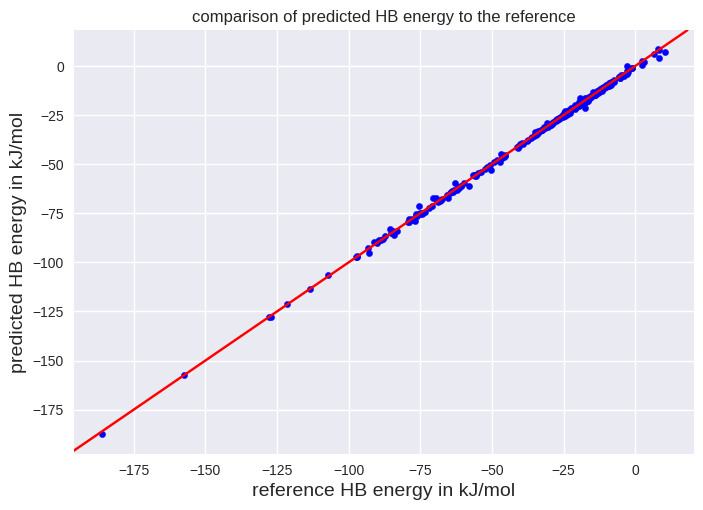

In [12]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

# The next line will add y=x to our graph 
plt.axline((0, 0), slope=1, color='r')
plt.scatter(y_test, final_predictions, color='b', s=20)
plt.xlabel("reference HB energy in kJ/mol", fontsize=14)
plt.ylabel("predicted HB energy in kJ/mol", fontsize=14)
plt.title("comparison of predicted HB energy to the reference")

plt.show()

We can store our model by:

In [7]:
import joblib

joblib.dump(model_final, "HB_energy.pkl")

['HB_energy.pkl']

You can use it later by:

In [6]:
import joblib
from sklearn.metrics import mean_absolute_error

y_test = test_set['energy']
X_test = test_set.drop(['energy'], axis=1)

final_model_reloaded = joblib.load("HB_energy.pkl")

test_stored_model = final_model_reloaded.predict(X_test)
final_mae = mean_absolute_error(y_test, test_stored_model)
print("The model has a mean absolute error of %0.2f kJ/mol on the test data set\n" % final_mae)

The model has a mean absolute error of 0.51 kJ/mol on the test data set



# Hands-on part

Your task is to develop a model which predicts the price of a house in California. You have a dataset from the 1990 U.S. census for this task. The full data set is available in Scikit-learn by "fetch_california_housing". We have created a csv file where we removed some entries. You can open the csv file as follow:   

In [6]:
import pandas as pd

housing = pd.read_csv('housing.csv')

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19599 entries, 0 to 19598
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MedInc     19599 non-null  float64
 1   HouseAge   19599 non-null  float64
 2   Latitude   19599 non-null  float64
 3   Longitude  19599 non-null  float64
 4   price      19599 non-null  float64
dtypes: float64(5)
memory usage: 765.7 KB


The price is the median house value for California districts, expressed in hundreds of thousands of dollars ($100,000). MedInc is the median income in a block group. A block group is represented by a population of 600 to 3000 people. Also the house age is normalized per block group.

You would like to make a regression model based on the k-nearest neighbor regression. An advantage of this model is that it requires no assumptions about the data. Furthermore, it has no training phase. The model is defined by the hyperparameters. A disadvantage is its high memory requirement because you need the full training data set for predictens. Furthermore, it struggles with imbalances classes. 

You should investigate the role of at least following hyperparameters:
<ul>
    <li>How many neighbors should be used to predict the price?</li>
    <li>Is it better to equally weight all neighbors or to give closer neighbors more weight?</li> 
</ul>
Information on the implementation of the k-nearest neighbors regressor in Scikit-learn can be found here: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html">Link</a>

In [7]:
from sklearn.model_selection import train_test_split
 
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(f"Instances of training data set:{train_set.shape}")
print(f"Instances of test data set:{test_set.shape}")

Instances of training data set:(15679, 5)
Instances of test data set:(3920, 5)


In [3]:
corr_matrix = train_set.corr()
print(corr_matrix["price"])

MedInc       0.650230
HouseAge     0.068858
Latitude    -0.147477
Longitude   -0.048017
price        1.000000
Name: price, dtype: float64


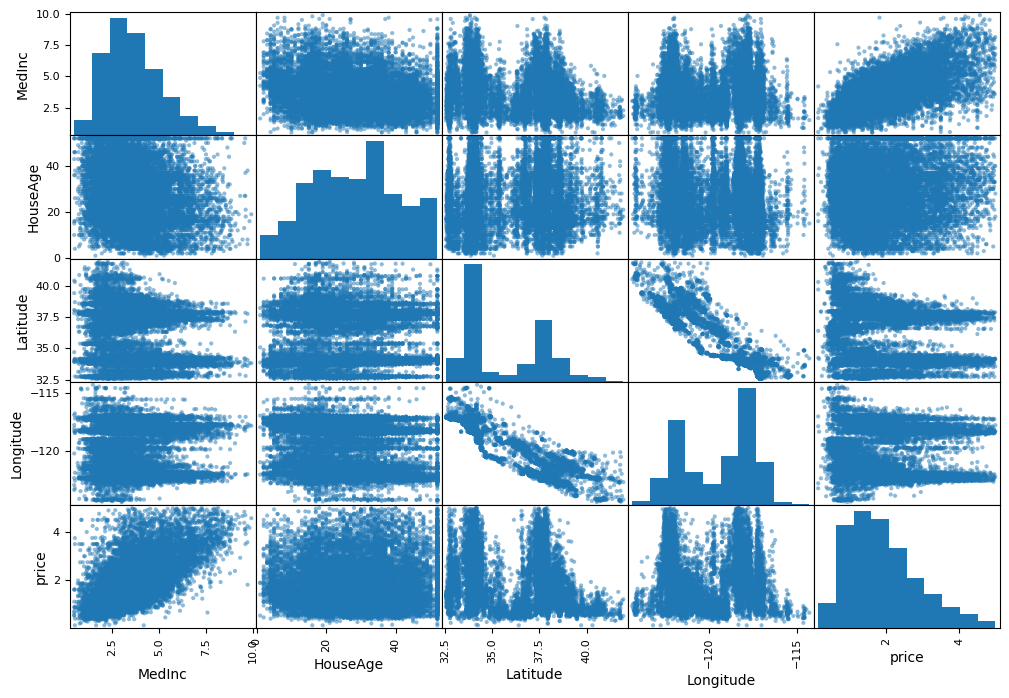

In [4]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

attributes = ['MedInc','HouseAge','Latitude', 'Longitude','price']
scatter_matrix(train_set[attributes], figsize=(12, 8))
plt.show()

In [11]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np
from sklearn.model_selection import cross_val_score

y_train = train_set['price']
X_train = train_set.drop(['price'], axis=1)

num_pipeline = make_pipeline(StandardScaler())

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),])
 
model_nearestneighbors = make_pipeline(preprocessing, KNeighborsRegressor())
#n_neighbors=3,p=1,weights='distance',algorithm='ball_tree'

model_nearestneighbors.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'columntransformer', 'kneighborsregressor', 'columntransformer__force_int_remainder_cols', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__num', 'columntransformer__num__memory', 'columntransformer__num__steps', 'columntransformer__num__transform_input', 'columntransformer__num__verbose', 'columntransformer__num__standardscaler', 'columntransformer__num__standardscaler__copy', 'columntransformer__num__standardscaler__with_mean', 'columntransformer__num__standardscaler__with_std', 'kneighborsregressor__algorithm', 'kneighborsregressor__leaf_size', 'kneighborsregressor__metric', 'kneighborsregressor__metric_params', 'kneighborsregressor__n_jobs', 'kneighborsregressor__n_neighbors', 'kneighborsregressor__p'

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kneighborsregressor__n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                 'kneighborsregressor__weights': ['uniform','distance'], 
                 }

grid_search = GridSearchCV(model_nearestneighbors, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

cv_hyperpara = pd.DataFrame(grid_search.cv_results_)
cv_hyperpara.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_hyperpara.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsregressor__n_neighbors,param_kneighborsregressor__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,0.013100,0.000936,0.035587,0.000959,12,distance,"{'kneighborsregressor__n_neighbors': 12, 'knei...",0.664082,0.676755,0.658169,0.658953,0.664220,0.664436,0.006653,1
21,0.012067,0.000184,0.031275,0.000142,11,distance,"{'kneighborsregressor__n_neighbors': 11, 'knei...",0.664940,0.676618,0.658016,0.656810,0.664808,0.664239,0.007042,2
19,0.012544,0.000402,0.030671,0.000674,10,distance,"{'kneighborsregressor__n_neighbors': 10, 'knei...",0.664638,0.675749,0.659777,0.656764,0.663794,0.664144,0.006459,3
25,0.014984,0.000693,0.040715,0.001296,13,distance,"{'kneighborsregressor__n_neighbors': 13, 'knei...",0.664317,0.676010,0.656934,0.658378,0.663505,0.663829,0.006723,4
27,0.014325,0.000779,0.039119,0.001867,14,distance,"{'kneighborsregressor__n_neighbors': 14, 'knei...",0.664248,0.677691,0.656149,0.657898,0.663111,0.663819,0.007576,5


In [9]:
model_final = make_pipeline(preprocessing,KNeighborsRegressor(n_neighbors=12,weights='distance'))

model_final.fit(X_train,y_train)

,steps,"[('columntransformer', ...), ('kneighborsregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

y_test = test_set['price']
X_test = test_set.drop(['price'], axis=1)

final_predictions = model_final.predict(X_test)
final_mae = mean_absolute_error(y_test, final_predictions)
print("The model has a mean absolute error of %0.2f\n" % final_mae)
final_maep = mean_absolute_percentage_error(y_test, final_predictions)
print("The model has a mean absolute percentage error of %0.2f\n" % final_maep)
final_rmse = root_mean_squared_error(y_test, final_predictions)
print("The model has a root mean square error of %0.2f\n" % final_rmse)
final_max = max_error(y_test, final_predictions)
print("The model has a maximum residual error of %0.2f\n" % final_max)
final_r2 = r2_score(y_test, final_predictions)
print("The model has a coefficient of determination of %0.2f\n" % final_r2)

The model has a mean absolute error of 0.40

The model has a mean absolute percentage error of 0.23

The model has a root mean square error of 0.56

The model has a maximum residual error of 3.15

The model has a coefficient of determination of 0.66



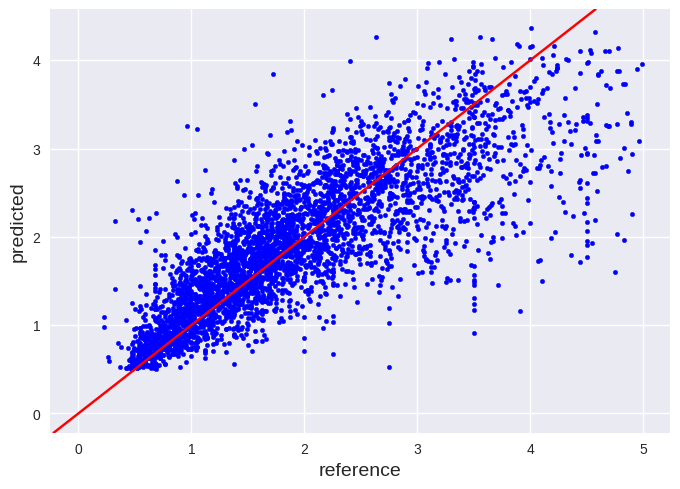

In [13]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

# The next line will add y=x to our graph 
plt.axline((0, 0), slope=1, color='r')
plt.scatter(y_test, final_predictions, color='b', s=10)
plt.xlabel("reference", fontsize=14)
plt.ylabel("predicted", fontsize=14)

plt.show()